# Petar i vuk: Realističan okoliš

U našoj situaciji, Petar se mogao kretati gotovo bez umaranja ili osjećaja gladi. U realističnijem svijetu, morao bi se povremeno odmoriti i nahraniti. Učinimo naš svijet realističnijim primjenom sljedećih pravila:

1. Krećući se s jednog mjesta na drugo, Petar gubi **energiju** i dobiva određenu **iscrpljenost**.
2. Petar može povećati energiju jedući jabuke.
3. Petar se može riješiti iscrpljenosti odmarajući se ispod stabla ili na travi (tj. ulaskom na polje s drvetom ili travom - zeleno polje).
4. Petar mora pronaći i ubiti vuka.
5. Kako bi ubio vuka, Petar mora imati određene razine energije i iscrpljenosti, inače gubi bitku.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

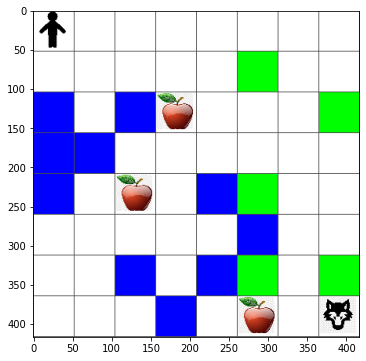

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Definiranje stanja

U našim novim pravilima igre, potrebno je pratiti energiju i umor u svakom stanju ploče. Stoga ćemo stvoriti objekt `state` koji će sadržavati sve potrebne informacije o trenutnom stanju problema, uključujući stanje ploče, trenutne razine energije i umora te mogućnost pobjede nad vukom u završnom stanju:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

Pokušajmo riješiti problem koristeći slučajnu šetnju i vidjeti hoćemo li uspjeti:


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Funkcija nagrađivanja

Funkcija nagrađivanja ključni je dio svakog sustava za učenje pojačanjem. Ona definira cilj koji agent pokušava postići i vodi njegovo ponašanje prema željenom ishodu.

### Što je funkcija nagrađivanja?

Funkcija nagrađivanja je matematička funkcija koja agentu dodjeljuje brojčanu vrijednost (nagradu) na temelju trenutnog stanja i/ili akcije koju je poduzeo. Cilj agenta je maksimizirati ukupnu nagradu tijekom vremena.

### Zašto je važna?

Dizajn funkcije nagrađivanja izravno utječe na uspješnost agenta. Ako je funkcija previše jednostavna, agent možda neće naučiti složena ponašanja. Ako je previše složena, može otežati proces učenja.

[!NOTE] Funkcija nagrađivanja ne mora nužno odražavati stvarnu korisnost u stvarnom svijetu. Umjesto toga, ona je alat za usmjeravanje agenta prema željenom cilju.

### Primjeri funkcija nagrađivanja

#### 1. Jednostavna funkcija nagrađivanja
```python
def reward_function(state, action):
    if state == "goal":
        return 1
    else:
        return 0
```
Ova funkcija daje nagradu od 1 kada agent postigne cilj, a 0 u svim ostalim slučajevima.

#### 2. Funkcija nagrađivanja temeljena na udaljenosti
```python
def reward_function(state, action):
    distance_to_goal = calculate_distance(state, goal_state)
    return -distance_to_goal
```
Ova funkcija koristi udaljenost do cilja kao negativnu nagradu, potičući agenta da minimizira udaljenost.

[!WARNING] Pazite da funkcija nagrađivanja ne potiče neželjena ponašanja. Na primjer, ako agent dobiva nagradu samo za kretanje, mogao bi beskonačno lutati bez postizanja cilja.

### Savjeti za dizajn funkcije nagrađivanja

- **Jasno definirajte cilj:** Funkcija nagrađivanja treba odražavati ono što želite da agent postigne.
- **Izbjegavajte dvostruke poruke:** Ako funkcija nagrađivanja daje kontradiktorne signale, agent može postati zbunjen.
- **Testirajte i iterirajte:** Dizajn funkcije nagrađivanja često zahtijeva eksperimentiranje i prilagodbe.

[!TIP] Počnite s jednostavnom funkcijom nagrađivanja i postupno je poboljšavajte kako biste postigli bolje rezultate.

### Zaključak

Funkcija nagrađivanja temelj je uspješnog učenja pojačanjem. Pažljivo osmišljen dizajn može značajno poboljšati učinkovitost i ponašanje agenta.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Q-Learning algoritam

Sam algoritam učenja ostaje gotovo nepromijenjen, samo koristimo `state` umjesto same pozicije na ploči.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

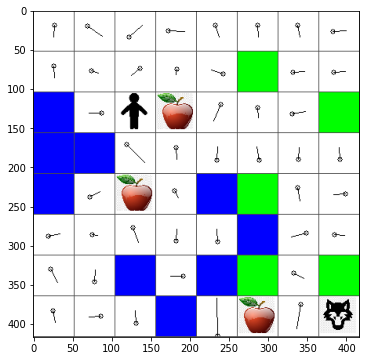

In [11]:
m.plot(Q)

## Rezultati

Pogledajmo jesmo li uspješno uvježbali Petra da se bori protiv vuka!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Sada vidimo mnogo manje slučajeva utapanja, ali Peter još uvijek ne uspijeva uvijek ubiti vuka. Pokušajte eksperimentirati i provjeriti možete li poboljšati ovaj rezultat igranjem s hiperparametrima.


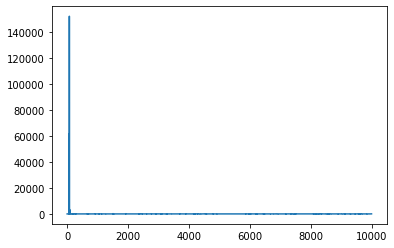

In [13]:
plt.plot(lpath)


---

**Odricanje od odgovornosti**:  
Ovaj dokument je preveden korištenjem AI usluge za prevođenje [Co-op Translator](https://github.com/Azure/co-op-translator). Iako nastojimo osigurati točnost, imajte na umu da automatski prijevodi mogu sadržavati pogreške ili netočnosti. Izvorni dokument na izvornom jeziku treba smatrati mjerodavnim izvorom. Za ključne informacije preporučuje se profesionalni prijevod od strane stručnjaka. Ne preuzimamo odgovornost za bilo kakva nesporazuma ili pogrešna tumačenja koja proizlaze iz korištenja ovog prijevoda.
